In [1]:
import argparse
from pathlib import Path
import os, sys, inspect

import logging

from stlarm import data, onto

In [2]:
STLARM_BASE_DIR = os.getenv('STLARM_BASE_DIR', '')

In [3]:
logging.basicConfig()
logger = logging.getLogger("stlarm")
logger.setLevel(logging.INFO)

In [4]:
FILTERED_NT = "resources/{}_filtered_triples.nt"
ALL_NT = "resources/{}_all_triples.nt"

In [5]:
def create_dirs():
    Path("cache").mkdir(parents=True, exist_ok=True)
    Path("resources").mkdir(parents=True, exist_ok=True)

def save_all(onto):
    filtered_nt = FILTERED_NT.format(onto.pretty_id)
    all_nt = ALL_NT.format(onto.pretty_id)
    onto.save(folder="cache")
    onto.save_filtered_triples(filtered_nt)
    onto.save_triples(all_nt)
    logger.info(f"Saved {str(type(onto))} at '{all_nt}' and '{filtered_nt}'.")

def get_available_data_sources():
    # Get the classes in stlarm.data which are concrete subclasses of data.TrajData
    classes = inspect.getmembers(
        data,  # data is the stlarm.data module
        lambda x: inspect.isclass(x)
        and not inspect.isabstract(x)
        and issubclass(x, data.TrajData),
    )
    return [c[0] for c in classes]

In [6]:
name = 'nyc_subset'
working_dir = '..'
data_source_cls= "NYCFoursquareData"
time_granularity = 'period'
max_hours_diff = 2
max_distance_km = 2
excluded_relations = []
dry_run = False
verbose = True

In [7]:
if verbose:
    logger.setLevel(logging.DEBUG)

STEP_ONTO_NAME = f"step_{name}"
CONVERTED_ONTO_NAME = f"converted_{name}"

# change working dir
os.chdir(working_dir)

# Create dirs if necessary
create_dirs()

In [8]:
# Instantiate data source class
data_src = getattr(data, data_source_cls)(apply_filtering=False)

data_df, trajs, traj_data = data_src.get_all_data(cids=["13_147_1", "13_147_2"])
logger.info(f"{data_df['uid'].nunique()} users")
logger.info(f"{data_df['tid'].nunique()} trajectories")
logger.info(f"{data_df['cid'].nunique()} checkins")
logger.info(f"{data_df['venue_id'].nunique()} venues")

INFO:stlarm.data:Processing data done in 7.04s.
INFO:stlarm:1 users
INFO:stlarm:1 trajectories
INFO:stlarm:2 checkins
INFO:stlarm:2 venues


In [9]:
step = onto.STEPRepresentation(
    name=STEP_ONTO_NAME,
    time_granularity=time_granularity,
    max_hours_diff=max_hours_diff,
    max_distance_km=max_distance_km,
    excluded_relations=excluded_relations,
)
step.gen_representation(trajs, traj_data=traj_data)
logger.info("STEP has %d individuals", len(list(step.onto.individuals())))

entity2entity: 100%|██████████| 3/3 [00:00<00:00, 601.02it/s]
INFO:stlarm.onto:Generating representation done in 0.05s.
INFO:stlarm:STEP has 26 individuals


In [13]:
!mkdir -p resources
ALL_NT = 'resources/{}_all_triples.nt'

In [14]:
ONTO_NAME_NT = ALL_NT.format(step.pretty_id)
step.save_triples(ONTO_NAME_NT)

DEBUG:stlarm.onto:Getting onto triples
DEBUG:stlarm.onto:[DONE] Getting onto triples


In [11]:
!python {STLARM_BASE_DIR}/../ontology-visualization/ontology_viz.py \
        -o {ONTO_NAME_NT}.dot \
        -C {STLARM_BASE_DIR}/../viz.config \
        {ONTO_NAME_NT}
!dot -Tpng -o {ONTO_NAME_NT}.png {ONTO_NAME_NT}.dot

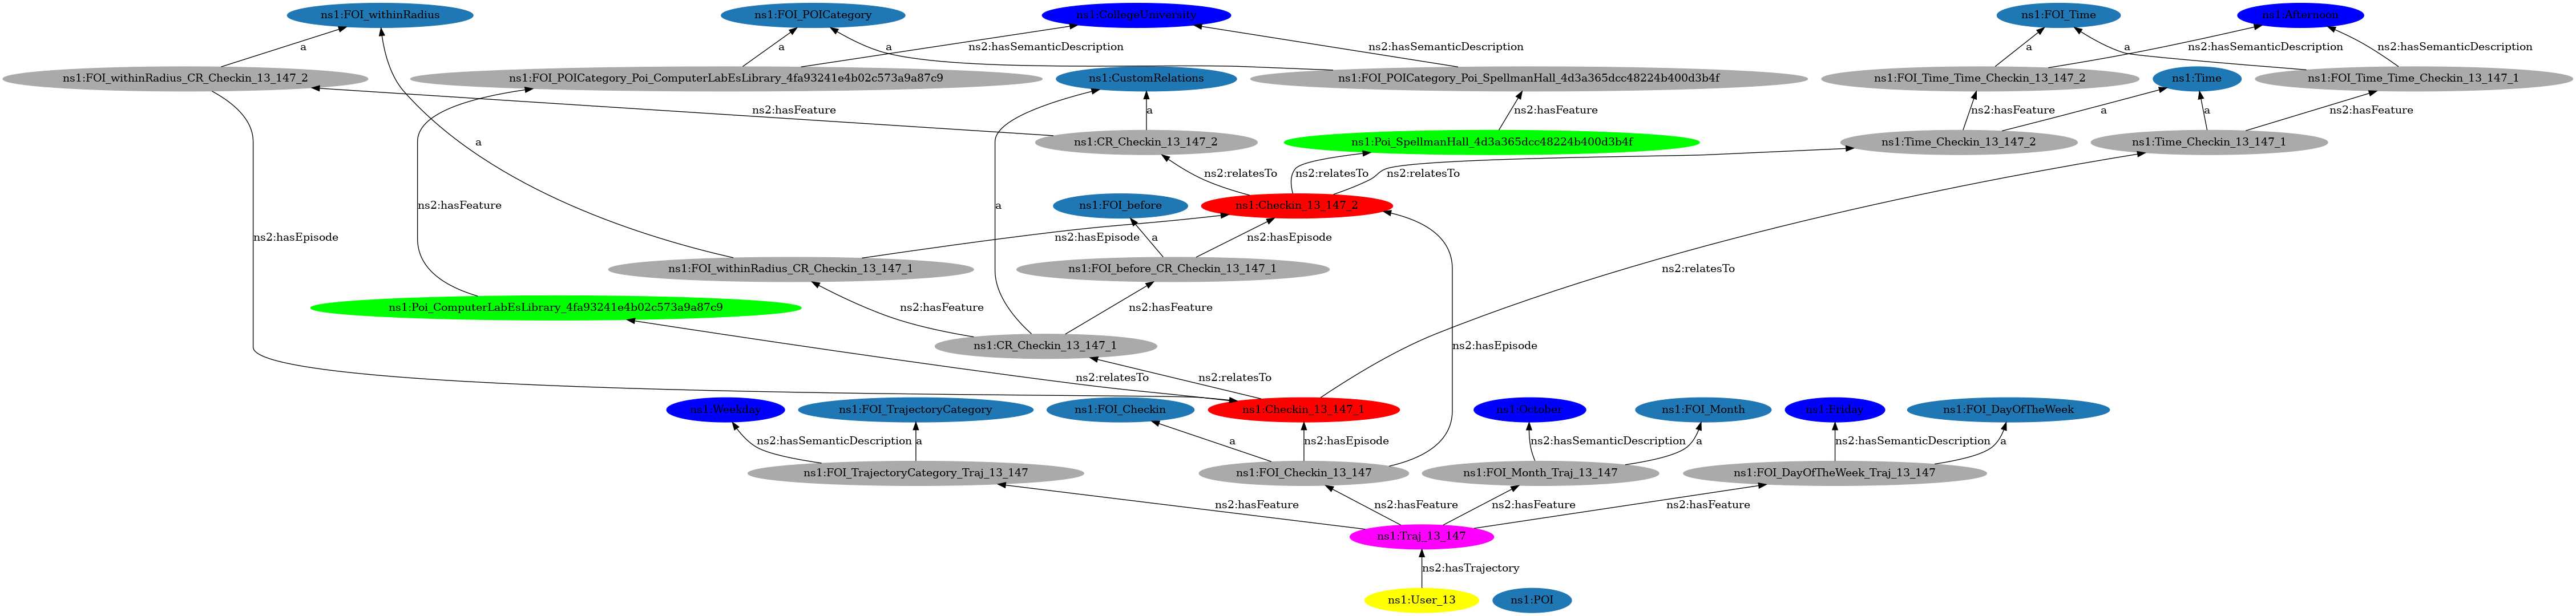

In [12]:
from IPython.display import Image
Image(ONTO_NAME_NT + '.png')

In [16]:
converted = step.to_custom_representation(name=CONVERTED_ONTO_NAME)
logger.info("CONVERTED has %d individuals", len(list(converted.onto.individuals())))

INFO:stlarm.onto_mapping:'step_mapping_to_custom_mapping' warm up done in 0.0s.
agents: 100%|██████████| 1/1 [00:00<00:00, 358.21it/s]
custom relations: 0it [00:00, ?it/s]
INFO:stlarm.onto:STEP to Custom done in 0.23s.
INFO:stlarm:CONVERTED has 11 individuals


In [17]:
ONTO_NAME_NT = ALL_NT.format(converted.pretty_id)
converted.save_triples(ONTO_NAME_NT)

DEBUG:stlarm.onto:Getting onto triples
DEBUG:stlarm.onto:[DONE] Getting onto triples


In [18]:
!python {STLARM_BASE_DIR}/../ontology-visualization/ontology_viz.py \
        -o {ONTO_NAME_NT}.dot \
        -C {STLARM_BASE_DIR}/../viz.config \
        {ONTO_NAME_NT}
!dot -Tpng -o {ONTO_NAME_NT}.png {ONTO_NAME_NT}.dot

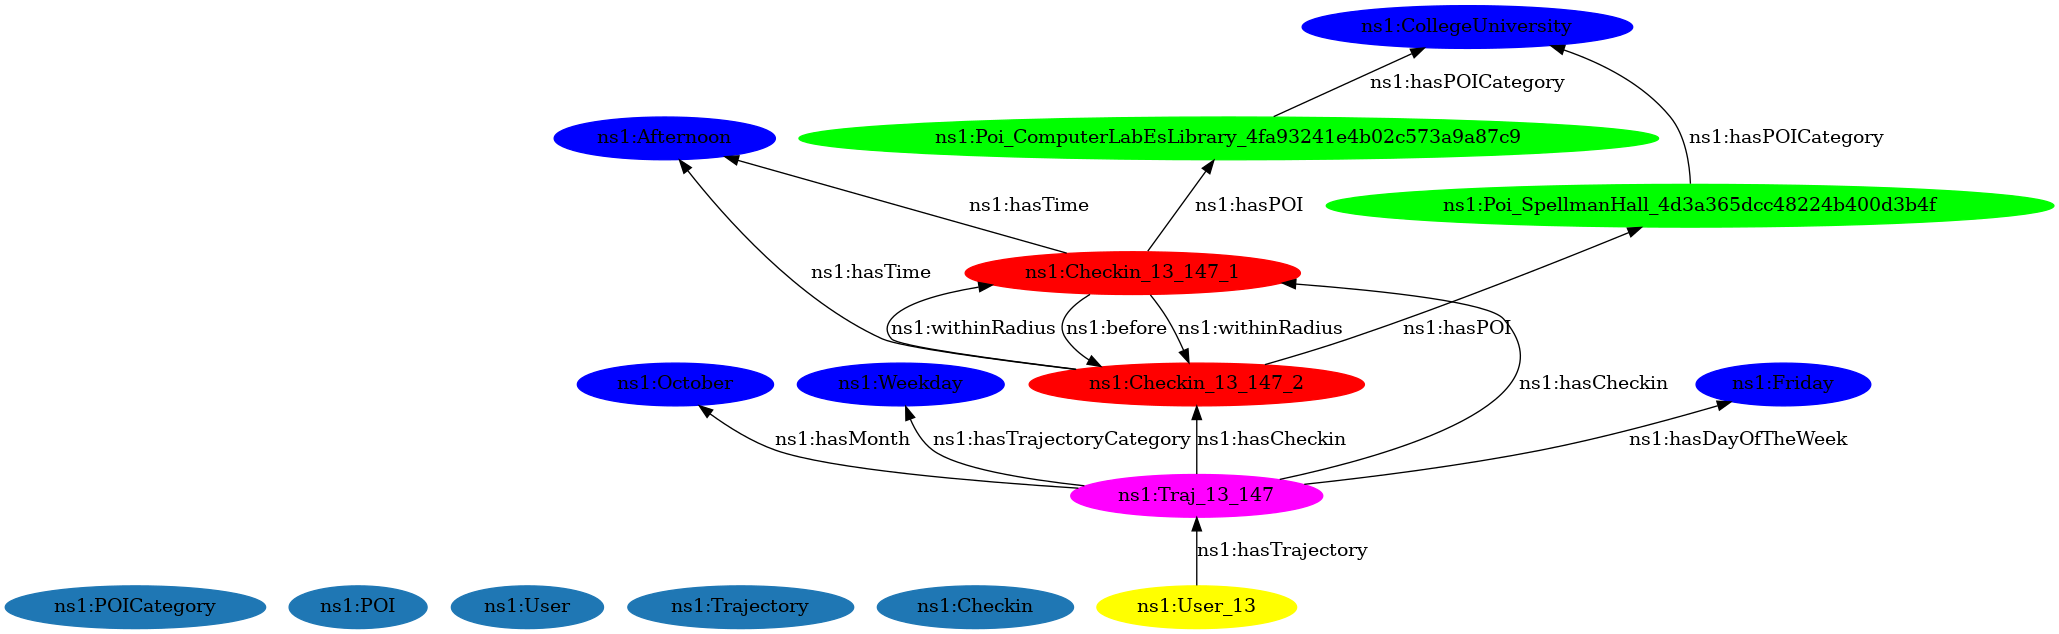

In [19]:
from IPython.display import Image
Image(ONTO_NAME_NT + '.png')